# Computational Social Science for Organizational Research
## Documents and Text

## Roadmap
 * Corpora
 * Documents as bags of words
 * Tokenizing
 * Stemming and lemmatization
 * Zipf's law
 * Cleaning out the bag
 * Document similarity
 * Tf-Idf weighting
 * Exercises
 
Natural language processing and related techniques represent, in my view, some of the most exciting areas of computational social science, especially for organizational researchers. As we all no doubt know from personal experience, organizations are great at generating massive amounts of documents. While that's always been true, digitization has taken it to a whole new level. Documents are the digital footprints of organizational activity. By studying documents, we can gain unprecedented insight into how organizations work. 

The challenge, however, is that much of the data we care about is highly unstructured, in the form of written text. Although traditional qualitative methods are valuable, the sheer scale of documents means that we can only read and evaluate a small subset of them by hand. You will also have trouble loading a text document into a rectangular matrix in your favorite statistical software.

In this session, you'll get a crash course in how to start analyzing documents and text.

# Corpora

Most typically, we'll use techniques from natural language processing when we have a large collection of documents that we would like to model or from which we would like to extract data or insights. In the land of natural language processing, a collection (or "body") of documents is called a [corpus](https://en.wikipedia.org/wiki/Text_corpus) (plural *corpora*). You can think of a corpus as your raw data. Most often, you'll probably be collecting a corpus of documents from some organization or research setting of interest, but there are also many publicly available corpora (often used for benchmarking new algorithms), like those from the [Linguistic Data Consortium](https://catalog.ldc.upenn.edu/).

To help make our explorations of natural language processing more concrete, let's put together a simple corpus. In particular, let's download the abstracts for all patents that are classified as "nanotechnology" (B82Y) by the Cooperative Patent Classificaion scheme. We can do so easily using the code below, which queries the Patents View Application Programming Interface (API). Don't worry if you don't follow all the API wrangling, which is a bit beyond the scope of what we want to cover today.

In [2]:
# load some packages
import requests
import pathlib
import pandas as pd

# set some configuration parameters
DATE_START = "1997-01-01"
DATE_END = "2003-12-31"
PER_PAGE = 9999
BASE_URL = "https://www.patentsview.org/api/patents/query"
CPC_GROUP_ID = "B82Y"

"""
# format our api query
params = {'q': '{"_and":[{"_gte":{"patent_date":"%s"}},{"_lt":{"patent_date":"%s"}},{"cpc_group_id":"%s"}]}' % (DATE_START, 
                                                                                                                DATE_END, 
                                                                                                                CPC_GROUP_ID),
          'f': '["patent_number","patent_date","patent_abstract"]',
          'o': '{"per_page":%s}' % (PER_PAGE,) }

# send the query to the server
r = requests.get(BASE_URL, params=params)

# save response as dict
abstracts_df = pd.DataFrame(r.json()["patents"]).set_index("patent_number")

# make a directory to store the data
pathlib.Path("pickles").mkdir(parents=True, exist_ok=True)

# save as pickle
abstracts_df.to_pickle("pickles/abstracts_df.pickle")
"""

# read from pickle
abstracts_df = pd.read_pickle("pickles/abstracts_df.pickle")

In [3]:
abstracts_df

,patent_date,patent_abstract
patent_number,,
5591238,1997-01-07,A method and nickel-containing catalyst are di...
5591487,1997-01-07,An information recording layer on a substrate ...
5591532,1997-01-07,A single layer film is deposited onto a substr...
5591690,1997-01-07,The present invention relates to a gettering m...
5591710,1997-01-07,Compositions and processes to alleviate oxygen...
...,...,...
6671141,2003-12-30,A ferromagnetic tunnel effective film has a fr...
6671301,2003-12-30,A semiconductor laser device including: a semi...
6671443,2003-12-30,A method for forming a hybrid active electroni...


# Documents as bags of words

Free-flowing text is too unstructured for computers to hanle. We're going to need to impose some order that will make a document look a bit more like traditional quantitative data (think rectangular matrices). There is a tradeoff here. On the one hand, by imposing structure, we're going to end up throwing away a lot of (important) information that is critical to a full understanding of the textual content of our documents. On the other hand, structure will also allow to use mathematical and statistical techniques, and therefore permit new kinds of insights on our corpus that would otherwise be impossible.

There are many different ways we could think about imposing structure on free flowing text. In this session, we're going to use what is known in natural language processing as the "bag of words" model. I love the name of the model because it's so descriptive. As you might guess from the name, under this model, we're not going to worry about word order. We can think of as a jumble of words all mixed up in a shopping bag. What we will care about is word frequency. The basic idea is that even if you don't know anything about the word order of a document, knowing the relative frequency of different words tells you some important information. 

As an example, consider the following two sentences, taken from the abstract of patent [10,563,325](http://patft1.uspto.gov/netacgi/nph-Parser?patentnumber=10563325).

> A method for making carbon fiber film includes growing a carbon nanotube array on a surface of a growth substrate.

We might represent this in a bag-of-words format as a Python tuple.

In [4]:
doc1 = ("A", "method", "for", "making", "carbon", "fiber", "film", "includes", "growing",
        "a", "carbon", "nanotube", "array", "on", "a", "surface", "of", "a", "growth", 
        "substrate.")

If we want a little more structure, we can also represent as a Python dictionary, with keys representing words, and values representing frequencies.

In [5]:
document_1 = {"a": 3, "carbon": 2, "A": 1, "method": 1, "for": 1, "making": 1, "fiber": 1,
              "film": 1, "includes": 1, "growing": 1, "nanotube": 1, "array": 1, "on": 1,
              "surface": 1, "of": 1, "growth": 1, "substrate.": 1}

This dictionary representation is nice, because it helps us to see that what we're essentially doing is treating documents as vectors of words. Note that we can easily extend this approach to multiple documents. Imagine that we encountered another nanotechnology patent that had the following sentence in its abstract.

> A method for making a carbon nanotube.

We can represent that patent using a dictionary just like we did before.

In [6]:
document_2 = {"A": 1, "method": 1, "for": 1, "making": 1, "a": 1, "carbon": 1, "nanotube.": 1}

And from there, it's not a big leap to think that we might represent both documents together in a matrix.

| term       | document_1 | document_2 |
|------------|------------|------------|
| a          | 3          | 1          |
| A          | 1          | 1          |
| array      | 1          | 0          |
| carbon     | 2          | 1          |
| fiber      | 1          | 0          |
| film       | 1          | 0          |
| for        | 1          | 1          |
| growing    | 1          | 0          |
| growth     | 1          | 0          |
| includes   | 1          | 0          |
| making     | 1          | 0          |
| method     | 1          | 1          |
| nanotube   | 1          | 1          |
| of         | 1          | 0          |
| on         | 1          | 0          |
| substrate. | 1          | 0          |
| surface    | 1          | 0          |

# Tokenizing

In the example above, we took some short snippets of text from two patents and represented them as vectors (or "bags of words"), where elements represent counts of words. Implicitly, then, we split each sentence into its constituent words, or tokens. For anyone who's learned how to read, that's a pretty straightforward task; something we can do quite effortlessly. But it turns out for a computer, splitting a text into its constitutent words can be quite a challenge, at least if you want quality results. In natural language processing, this task is called __tokenization__. 

Probably the simplest way to tokenize a sentence is to split on white space. 

In [7]:
s = "I love visiting New York. It's so much fun---I visit whenever I can!"
s.split()

['I',
 'love',
 'visiting',
 'New',
 'York.',
 "It's",
 'so',
 'much',
 'fun---I',
 'visit',
 'whenever',
 'I',
 'can!']

Not bad, but there are a few problems. "New York" was split into two words, which, although correct in some sense, does not correspond to the fact that in this sentence, "New" and "York" are functioning as a single unit. In addition, notice that "York" still has a period attached at the end, and "can" has an exclamation point. Finally, our technique treats "fun---I" as a single word.

Instead of splitting on white space, we can do a little better by splitting on word boundaries (e.g., punctuation, white space). In Python, we can do that easily using a regular expression.

In [8]:
import re
re.split(r"\b", s)

['',
 'I',
 ' ',
 'love',
 ' ',
 'visiting',
 ' ',
 'New',
 ' ',
 'York',
 '. ',
 'It',
 "'",
 's',
 ' ',
 'so',
 ' ',
 'much',
 ' ',
 'fun',
 '---',
 'I',
 ' ',
 'visit',
 ' ',
 'whenever',
 ' ',
 'I',
 ' ',
 'can',
 '!']

We've made some improvement, like separating words from punctuation. But some problems remain, like "New York" being split. We've also introduced some __new__ problems, like "It's" now being split into "It" and "'s". It is possible to do a bit better by using some fancier regular expressions. But you're still going to miss tricky cases like "New York." 

Although we can spend a lot of time worrying about the quality of our tokenization, it reality, even fairly unsophisticated approaches like the ones we've just explored can produce reasonable results, depending on what you're trying to do. Still, it's not hard to get our hands on a more sophisticated tokenizer. 

We'll be using a package called spaCy for most of this session. Let's see whether its tokenizer improves on our previous attempts.

In [9]:
# load spacy
import spacy

# load model
nlp = spacy.load("en_core_web_lg") 

# run nlp on our sentence
[token.text for token in nlp(s)]

['I',
 'love',
 'visiting',
 'New',
 'York',
 '.',
 'It',
 "'s",
 'so',
 'much',
 'fun',
 '---',
 'I',
 'visit',
 'whenever',
 'I',
 'can',
 '!']

Not really! Still, for most use cases, an industrial strength tokenizer (like spaCy) is going to perform better than our word-boundary approach.

# Stemming and lemmatization

Let's take a look at a vector representation of the tokens from our favorite sentence.

In [10]:
# load collections
import collections

# make a vector of counts
collections.Counter([token.text for token in nlp(s)])

Counter({'I': 3,
         'love': 1,
         'visiting': 1,
         'New': 1,
         'York': 1,
         '.': 1,
         'It': 1,
         "'s": 1,
         'so': 1,
         'much': 1,
         'fun': 1,
         '---': 1,
         'visit': 1,
         'whenever': 1,
         'can': 1,
         '!': 1})

Notice that our vector treats "visit" and "visiting" as two distinct words. Of course, these morphological differences are gramatically important in written texts, but in our bag of words model, we've done away with grammar. So for our purposes, we might want to treat "visit" and "visiting" as the same word. We can do so by applying two related techniques, stemming and lemmatization.

As the name suggests, stemming entails reducing words to their "stems" by removing tenses, plurals, and related morphological information. So, for example, here is an example of various forms of the word "participate" taken to their stems.

| word          | stem     |
|---------------|----------|
| participate   | particip |
| participating | particip |
| participated  | particip |
| participation | particip |
| participates  | particip |

Lemmatization is similar to stemming, but rather groups together common words by their "canonical" or "dictionary" form. The upshot is that while stems are not necessarily themselves actual words, lemmas are. To round out the example, here are the lemmas for our variations on "participate."

| word          | stem          |
|---------------|---------------|
| participate   | participate   |
| participating | participate   |
| participated  | participate   |
| participation | participation |
| participates  | participate   |

As you might have guessed, we can get lemmas easily in spaCy. Let's go back to our nanotechnology example, and pull the lemmas for the abstract for patent 5531930. 

In [11]:
patent_5591238_abstract = abstracts_df.loc["5591238"].patent_abstract
patent_5591238_lemmas = [token.lemma_ for token in nlp(patent_5591238_abstract)]
patent_5591238_lemmas = collections.Counter(patent_5591238_lemmas)
patent_5591238_lemmas.most_common(15)

[('a', 2),
 ('-', 2),
 ('contain', 2),
 ('compound', 2),
 ('method', 1),
 ('and', 1),
 ('nickel', 1),
 ('catalyst', 1),
 ('be', 1),
 ('disclose', 1),
 ('for', 1),
 ('prepare', 1),
 ('synthesis', 1),
 ('gas', 1),
 ('by', 1)]

# Zipf's law

Although it may not seem like much, we can already start doing some interesting analyses using the tools we've learned so far. Let's try a quick applications to get a better feel for what we can do...and to learn a bit more about our nanotechnology patents. 

Some words are much more common than others. Words like "the," "and," and "are" appear many times per document, while words like "hurlyburly," "piquant," and "vituperate" might appear only a few times in an entire corpus (though exactly which words are common or rare depends on the content of the corpus). If we plot a frequency distribution of words, we'll notice that they follow a pattern such that the frequency of a word is roughly inversely proportional to its rank, i.e.,

$$ n \propto \frac{1}{r^\alpha}$$,

where $n$ is the expected frequency, $r$ is the rank, and $\alpha$ is a scalining parameter, typically estimated to be close to 1. This phenomenon is known as Zipf's Law. Let's investigate Zipf's Law using some of the tools we've just learned.

In [12]:
# create a list to hold tokens
tokens = []

# loop over abstracts and pull tokens
for patent_abstract in abstracts_df.patent_abstract:
  tokens.extend([token.text for token in nlp(patent_abstract, disable=["ner","parser"])])

In [13]:
# make a vector of counts
token_counts = collections.Counter(tokens)

# make a series
tokens_s = pd.Series(token_counts).sort_values(ascending=False)

Finally, let's plot the result on a log-log plot. We'll be hoping to see a more or less straight line running from the top left corner of the plot to the bottom right.

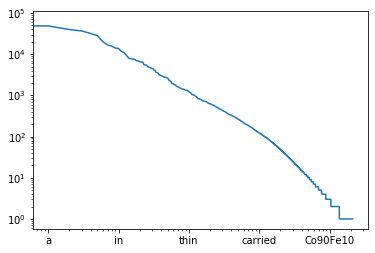

In [14]:
# make a log-log plot
tokens_s.plot(loglog=True)

# Cleaning out the bag

So far, we've gone from natural language text to a bag of words. Our main trick for doing so was to split words into discrete tokens and to throw them into some sort of list or vector. We also learned that we could reduce some noise in our bag of words by collapsing different forms into a common stem or lemma.

But out bag of words is still quite messy. Let's take a look at some of the most common things we'll see when we reach inside. 

In [15]:
token_counts.most_common(15)

[('the', 63092),
 ('a', 48567),
 ('of', 39551),
 (',', 36676),
 ('.', 31833),
 ('and', 28026),
 ('to', 19977),
 ('is', 16836),
 ('-', 15624),
 ('layer', 14111),
 ('in', 13745),
 ('The', 11660),
 ('an', 10927),
 ('for', 9233),
 (')', 7999)]

A few things stand out. First, some of the most common tokens in our bag are not words at all, but punctuation. We also have the same word being treated as two different tokens based on capitalization ("The" and "the"). Typically, before you start doing any serious textual analysis, you'll want to clean up your bag of words a bit. These steps, usually called preprocessing, typically entail things like removing punctuation, changing all tokens to a common case (e.g., all lower case), lemmatization, and so forth. The particular steps you end up taking will depend a lot on the nature of your data. So let's clean up our patent abstracts a little. We'll hold our preprocessed tokens in a new column of our data frame. We'll start by defining a function that will do the preprocessing.

In [16]:
# set some configuration parameters
MIN_TOKEN_LENGTH = 2
MAX_TOKEN_LENGTH = 50

# define our function
def preprocess_patent_abstract(patent_abstract):
  """preprocess a patent abstract"""
  
  # create a list to save the preprocessed tokens
  patent_abstract_pp = []
    
  # tokenize
  patent_abstract_nlp = nlp.tokenizer(patent_abstract)
    
  # loop over the tokens and keep only what we want
  for token in patent_abstract_nlp:
    if (token.is_stop is False 
        and token.is_punct is False 
        and token.is_digit is False 
        and token.is_space is False
        and len(token) > MIN_TOKEN_LENGTH
        and len(token) < MAX_TOKEN_LENGTH):
        patent_abstract_pp.append(token.lemma_.lower())    
    
  # return our cleaned up tokens
  return patent_abstract_pp 

In [17]:
abstracts_df["patent_abstract_pp"] = abstracts_df.patent_abstract.apply(preprocess_patent_abstract)
abstracts_df.head()

,patent_date,patent_abstract,patent_abstract_pp
patent_number,,,
5591238,1997-01-07,A method and nickel-containing catalyst are di...,"[method, nickel, contain, catalyst, disclose, ..."
5591487,1997-01-07,An information recording layer on a substrate ...,"[information, record, layer, substrate, provid..."
5591532,1997-01-07,A single layer film is deposited onto a substr...,"[single, layer, film, deposit, substrate, room..."
5591690,1997-01-07,The present invention relates to a gettering m...,"[present, invention, relate, gettering, materi..."
5591710,1997-01-07,Compositions and processes to alleviate oxygen...,"[compositions, process, alleviate, oxygen, tox..."


Feels good to be clean!

# Document similarity

When we're working with textual data, one of the most common things we'll want to do is make comparisons among documents based on how similar or different they are. The canonical example of this comes from information retrieval, where we might be given a string (e.g., as a query from a user of a search engine) and we want to find the set of documents that are most similar. Returning to our running example for this session, we might be interested in knowing how similar or different a particular nanotechnology patent is from other nanotechnology patents, under the idea that more distinctive patents might represent more radical innovations.

We already have many of the tools we need to start comparing documents. As I noted a while back, the beauty of representing our documents as vectors is that we can treat them like mathematical objects. Rather than inventing new techniques for comparing documents based on their textual similarity, we can use standard distance metrics, of which there are many. In natural language processing, the most widely used is cosine distance (similarity), which characterizes distance between vectors based on their angle of separation in a vector space. Cosine distance has several nice properties. When the vector elements are positive integers (which is what we'll have for our document vectors), the measure ranges from 0 to 1, which makes interpretation easy. In addition, unlike other metrics (e.g., Euclidean distance), cosine distance is not sensitive to document size. Let's take a quick look at a few examples.

In [18]:
# load scipy distance library
import scipy.spatial.distance

# create some dummy documents
doc1 = [2,4,6,8,10]
doc2 = [4,8,12,16,20]
doc3 = [2,4,6,8,10]
doc4 = [2,4,6,0,0]

# doc1, doc2
print("doc1 vs. doc2 euclidean: {}".format(scipy.spatial.distance.euclidean(doc1, doc2)))
print("doc1 vs. doc2 cosine: {}".format(scipy.spatial.distance.cosine(doc1, doc2)))

# doc3, doc4
print("doc3 vs. doc4 euclidean: {}".format(scipy.spatial.distance.euclidean(doc3, doc4)))
print("doc3 vs. doc4 cosine: {}".format(scipy.spatial.distance.cosine(doc3, doc4)))

doc1 vs. doc2 euclidean: 14.832396974191326
doc1 vs. doc2 cosine: 0.0
doc3 vs. doc4 euclidean: 12.806248474865697
doc3 vs. doc4 cosine: 0.495475020890487


Now, let's compute the cosine similarity for some real abstracts. First, we'll need to get a vector representation for each abstract we want to compare. We can do this using the methods we learned above. The trick here is that we need to make sure the two vectors we want to compare all contain the same elements. That means, for example, that if the word "nanotube" appears in abstract A but not abstract B, we still need to represent "nanotube" in vector B, but with a count of 0. In addition, we need to make sure that the vectors are aligned by dimension, such that the words are in the same order. Here is a little function that will take two lists of tokens and compute their cosine similarity.

In [19]:
# define our function
def cosine_similarity_from_token_lists(tl1, tl2):
  """return cosine similarity from two token lists."""
  
  # make sure we have data in both lists
  if len(tl1) < 1 or len(tl2) < 1:
    return None

  # create a list with the common tokens
  common_tokens = list(set(tl1 + tl2))

  # create lists to hold counts for tl1 and tl2
  tl1_counts = []
  tl2_counts = []

  # loop over common_tokens and fill lists of counts
  for common_token in common_tokens:
    
    # add count of common token to tl1_counts
    tl1_counts.append(tl1.count(common_token))
    
    # add count of common token to tl1_counts
    tl2_counts.append(tl2.count(common_token))
  
  # compute cosine similarity
  cosine_similarity = 1.0 - scipy.spatial.distance.cosine(tl1_counts, tl2_counts)  
  
  # return the result
  return cosine_similarity

What's nice about defining a function is that we can write the code once and use it over and over again. And, if we want to make a change later on, we just need to edit in one place. Now that we've got our function, let's run some comparisons. The code below will select two random patents and give their textual similarity.

In [20]:
# randomly select a first abstract
patent_abstract_1 = abstracts_df.sample(1).iloc[0].patent_abstract_pp

# randomly select a second abstract
patent_abstract_2 = abstracts_df.sample(1).iloc[0].patent_abstract_pp

# get cosine similarity
cosine_similarity_from_token_lists(patent_abstract_1, patent_abstract_2)

0.03209824257403826

As a final example, let's compare the similarity of nanotechnology patents across years. Perhaps that will give us a sense for technological change in the area.

In [21]:
# create a variable to hold years
abstracts_df["year"] = pd.DatetimeIndex(abstracts_df.patent_date).year

# pull a random sample to speed up computation
abstracts_df_sample = abstracts_df.sample(2500)

# create a list to save the results
results = []

# loop over unique years
for year_i in abstracts_df["year"].unique():
  
  # save the individual comparisons in a list
  results_year = []

  # pull the tokens for year_i
  year_i_tokens = [token for document in abstracts_df_sample.loc[abstracts_df["year"] == year_i].patent_abstract_pp 
                         for token in document]

  # pull the tokens for year_j
  for year_j in abstracts_df["year"].unique():
   
    # pull the tokens for year_j
    year_j_tokens = [token for document in abstracts_df_sample.loc[abstracts_df["year"] == year_j].patent_abstract_pp 
                           for token in document]
    
    # append our comparison
    results_year.append(cosine_similarity_from_token_lists(year_i_tokens, year_j_tokens))
  
  # save the results from the year to the overall list
  print("finished comparisons for {}!".format(year_i))
  results.append(results_year)

finished comparisons for 1997!
finished comparisons for 1998!
finished comparisons for 1999!
finished comparisons for 2000!
finished comparisons for 2001!
finished comparisons for 2002!
finished comparisons for 2003!


Now let's see what the results look like.

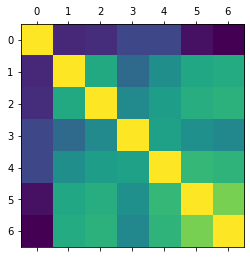

In [22]:
# load a few libraries
import numpy as np
import matplotlib.pyplot as plt

# convert our result to a numpy array
results = np.array(results)

# plot using matplotlib
plt.matshow(results)

# Tf-Idf weighting

In our previous example, we looked at the textual similarity of nanotechnology patents across years. Looking at the heat map, we see higher similarity among adjacent years and lower similarity among years that are more distant. At the same time, if you look at the actual similarities, you'll notice they're all quite high (e.g., in the 0.8s and 0.9s). There may be good substantive reasons for seeing such high similarities (e.g., maybe nanotechnology doesn't change that much from year to year, which certainly seems plausible). At the same time, some features of how we've defined our bag of words may be contributing to the high similarities we observe. 

In particular, consider that there are some terms that are likely to appear almost all nanotechnology patents (and with high frequency), e.g., "nanotechnology," "carbon," "method," "device." Because these terms are so common, they don't really tell us much about how similar or different two patents are, or how similar or different patents are across years. 

There are several techniques to deal with these challenges in natural language processing. One that we've already implemented is the removal of stop words (e.g., "the", "is", "and"). Another technique (often used on conjunction with stop word removal) is term weighting. Specifically, we would like to give some terms greater weight than others. 

One of the most common metrics for term weighting is called term frequency-inverse document frequency weighting, or TF-IDF for short. The idea is that we want to weight terms more highly when they appear more frequently within a particular document and less highly when they appear more commonly across documents.

The code below will run through the steps of TF-IDF weighting. Our first step is to get document frequencies for each token. We can make use of some of our previous work here, specifically our cleaned set of tokens, held in `abstracts_df["patent_abstract_pp"]`.

In [26]:
# create a dictionary to hold our frequencies
token_document_freqs = collections.Counter()

# loop over abstract tokens and get document frequencies
for patent_abstract_tokens in abstracts_df["patent_abstract_pp"]:
  token_document_freqs.update(set(patent_abstract_tokens))

# check out our list of document frequencies
token_document_freqs.most_common(15)

Right now, we have document frequencies. Typically, though, we will want *inverse* document frequencies. We'll also usually want to log transform our weights. So let's do a last little bit of processing.

In [33]:
# create a dictionary to hold our inverse frequencies
token_inverse_document_freqs = {}

# loop over tokens to get inverse document frequencies
for token, document_freq in token_document_freqs.items():
  token_inverse_document_freqs[token] = np.log(len(abstracts_df)/document_freq) + 1

# check out some document frequencies
pd.Series(token_inverse_document_freqs)

disclose         3.179715
hydrocarbyl      8.417220
catalyst         5.247534
compound         3.500163
synthesis        4.920712
                  ...    
ohgr;cm         10.026658
1&times;1010    10.026658
evarnescent     10.026658
stochastic      10.026658
obscure         10.026658
Length: 15077, dtype: float64

We've already written a function to compute cosine similarity, but with the way we've currently written the function, we cannot make use of tf-idf weights. Let's make some adjustments to allow us to incorporate weights for our terms.

In [42]:
# define our function
def cosine_similarity_tfidf_weighted_from_token_lists(tl1, tl2, token_inverse_document_freqs=None):
  """return tf-idf weighted cosine similarity from two token lists."""
  
  # make sure we have data in both lists
  if len(tl1) < 1 or len(tl2) < 1:
    return None

  # create a list with the common tokens
  common_tokens = list(set(tl1 + tl2))

  # create lists to hold counts for tl1 and tl2
  tl1_counts = []
  tl2_counts = []

  # loop over common_tokens and fill lists of counts
  for common_token in common_tokens:
    
    # add count of common token to tl1_counts
    if token_inverse_document_freqs is not None:
      tl1_counts.append(tl1.count(common_token) * token_inverse_document_freqs[common_token])
    else:
      tl1_counts.append(tl1.count(common_token))
    
    # add count of common token to tl1_counts
    if token_inverse_document_freqs is not None:
      tl2_counts.append(tl2.count(common_token) * token_inverse_document_freqs[common_token])
    else:
      tl2_counts.append(tl2.count(common_token))
  
  # compute cosine similarity
  cosine_similarity = 1.0 - scipy.spatial.distance.cosine(tl1_counts, tl2_counts)  
  
  # return the result
  return cosine_similarity

Let's give it a whirl.

In [43]:
# randomly select a first abstract
patent_abstract_1 = abstracts_df.sample(1).iloc[0].patent_abstract_pp

# randomly select a second abstract
patent_abstract_2 = abstracts_df.sample(1).iloc[0].patent_abstract_pp

# get cosine similarity
cosine_similarity_tfidf_weighted_from_token_lists(patent_abstract_1, 
                                                  patent_abstract_2,
                                                  token_inverse_document_freqs=token_inverse_document_freqs)

0.05081667940277612

# Exercises

  * Update code used to generate the heat map with similarity among years to use tf-idf weights. How do the results change from the unweighted map?
  * Write some code that will compute the average similarity between a focal patent and another set of patens. Can you identify any unique features of patents with high versus low similarity to others in their fields?